In [3]:
import numpy as np
np.random.seed(42)  # 再現性のため

# データ生成（実際の提出では以下の配列をそのまま使用）
data_20s = np.random.normal(4.2, 0.8, 15).round().clip(1, 5).astype(int)
data_40s = np.random.normal(3.5, 0.9, 15).round().clip(1, 5).astype(int)
data_60s = np.random.normal(2.8, 1.1, 15).round().clip(1, 5).astype(int)

print("20代:", list(data_20s))
print("40代:", list(data_40s))
print("60代:", list(data_60s))

20代: [np.int64(5), np.int64(4), np.int64(5), np.int64(5), np.int64(4), np.int64(4), np.int64(5), np.int64(5), np.int64(4), np.int64(5), np.int64(4), np.int64(4), np.int64(4), np.int64(3), np.int64(3)]
40代: [np.int64(3), np.int64(3), np.int64(4), np.int64(3), np.int64(2), np.int64(5), np.int64(3), np.int64(4), np.int64(2), np.int64(3), np.int64(4), np.int64(2), np.int64(4), np.int64(3), np.int64(3)]
60代: [np.int64(2), np.int64(5), np.int64(3), np.int64(2), np.int64(4), np.int64(1), np.int64(3), np.int64(1), np.int64(1), np.int64(3), np.int64(4), np.int64(3), np.int64(3), np.int64(2), np.int64(1)]


In [6]:
from scipy import stats

# Kruskal-Wallis検定を実行
statistic, p_value = stats.kruskal(data_20s, data_40s, data_60s)

print(f"\nKruskal-Wallis 検定統計量 (H): {statistic:.3f}")
print(f"p値: {p_value:.3f}")

# 統計的有意性の判定
alpha = 0.05
if p_value < alpha:
    print(f"\np値 ({p_value:.3f}) は有意水準 ({alpha}) 未満です。")
    print("よって、帰無仮説を棄却します。少なくとも1つの年代間で中央値に統計的に有意な差があると結論できます。")
else:
    print(f"\np値 ({p_value:.3f}) は有意水準 ({alpha}) 以上です。")
    print("よって、帰無仮説を棄却できません。年代間で中央値に統計的に有意な差があるとは言えません。")


Kruskal-Wallis 検定統計量 (H): 16.608
p値: 0.000

p値 (0.000) は有意水準 (0.05) 未満です。
よって、帰無仮説を棄却します。少なくとも1つの年代間で中央値に統計的に有意な差があると結論できます。


In [13]:
# Kruskal-Wallis検定の結果、有意差があった場合の多重比較
if p_value < alpha:
    print("\n--- Mann-Whitney U検定による多重比較 (Bonferroni補正適用) ---")

    # Bonferroni補正後の有意水準
    num_comparisons = 3 # 20s vs 40s, 20s vs 60s, 40s vs 60s
    alpha_corrected = alpha / num_comparisons
    print(f"Bonferroni補正後の有意水準: {alpha_corrected:.4f}")

    comparisons = [
        ("20代", "40代", data_20s, data_40s),
        ("20代", "60代", data_20s, data_60s),
        ("40代", "60代", data_40s, data_60s)
    ]

    for name1, name2, data1, data2 in comparisons:
        u_statistic, p_val_mw = stats.mannwhitneyu(data1, data2, alternative='two-sided') # 両側検定
        print(f"\n{name1} vs {name2}:")
        print(f"  Mann-Whitney U統計量: {u_statistic:.3f}")
        print(f"  p値 (補正前): {p_val_mw:.3f}")
        # Z値の計算 (p値から逆算)
        # Mann-Whitney U検定のp値は通常両側検定のp値なので、片側検定のp値にするために2で割る
        # その後、標準正規分布の逆累積分布関数でZ値を求める
        # U統計量が期待値 (n1*n2/2) より小さい場合は負のZ値、大きい場合は正のZ値となる
        expected_u = len(data1) * len(data2) / 2
        if u_statistic < expected_u:
            z_value = stats.norm.ppf(p_val_mw / 2) # 左側（負のZ値）
        else:
            z_value = -stats.norm.ppf(p_val_mw / 2) # 右側（正のZ値）

        # r効果量の計算
        total_n = len(data1) + len(data2)
        r_effect_size = z_value / np.sqrt(total_n)

        print(f"  推定Z値: {z_value:.3f}")
        print(f"  r効果量: {r_effect_size:.3f}")

        # r効果量の解釈
        abs_r = abs(r_effect_size)
        if abs_r < 0.1:
            effect_interpretation = "非常に小さい効果（実質的な差は無視できる）"
        elif abs_r < 0.3:
            effect_interpretation = "小程度の効果"
        elif abs_r < 0.5:
            effect_interpretation = "中程度の効果"
        else:
            effect_interpretation = "大規模な効果"
        print(f"  => 効果量の解釈: {effect_interpretation}")

        if p_val_mw < alpha_corrected:
            print(f"  => 有意差あり (p < {alpha_corrected:.4f})")
        else:
            print(f"  => 有意差なし (p >= {alpha_corrected:.4f})")

else:
    print("\nKruskal-Wallis検定で有意差がなかったため、多重比較は実施しません。")


--- Mann-Whitney U検定による多重比較 (Bonferroni補正適用) ---
Bonferroni補正後の有意水準: 0.0167

20代 vs 40代:
  Mann-Whitney U統計量: 184.000
  p値 (補正前): 0.002
  推定Z値: 3.085
  r効果量: 0.563
  => 効果量の解釈: 大規模な効果
  => 有意差あり (p < 0.0167)

20代 vs 60代:
  Mann-Whitney U統計量: 197.000
  p値 (補正前): 0.000
  推定Z値: 3.584
  r効果量: 0.654
  => 効果量の解釈: 大規模な効果
  => 有意差あり (p < 0.0167)

40代 vs 60代:
  Mann-Whitney U統計量: 149.500
  p値 (補正前): 0.114
  推定Z値: 1.580
  r効果量: 0.288
  => 効果量の解釈: 小程度の効果
  => 有意差なし (p >= 0.0167)



--- データ可視化 (Matplotlibのみ) ---


/var/folders/jy/h_rhr__15mn045khph171y6w0000gn/T/ipykernel_93362/2188223131.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels, patch_artist=True) # patch_artist=True で箱を塗りつぶせるようにする


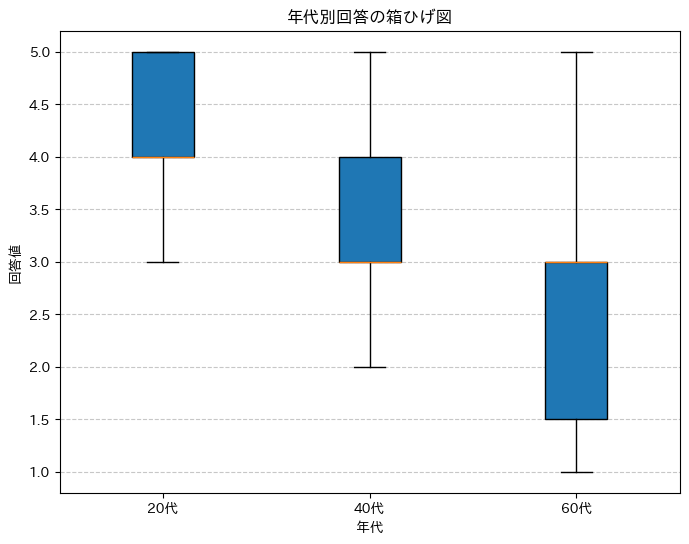

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# データを可視化のために整形
# 各年代のデータをリストに格納
data_to_plot = [data_20s, data_40s, data_60s]
labels = ['20代', '40代', '60代']

print("\n--- データ可視化 (Matplotlibのみ) ---")

# 1. 箱ひげ図 (Box Plot)
plt.figure(figsize=(8, 6))
plt.boxplot(data_to_plot, labels=labels, patch_artist=True) # patch_artist=True で箱を塗りつぶせるようにする
plt.title('年代別回答の箱ひげ図')
plt.xlabel('年代')
plt.ylabel('回答値')
plt.grid(axis='y', linestyle='--', alpha=0.7)


for patch, color in zip(plt.gca().artists):
    patch.set_facecolor(color)

plt.show()


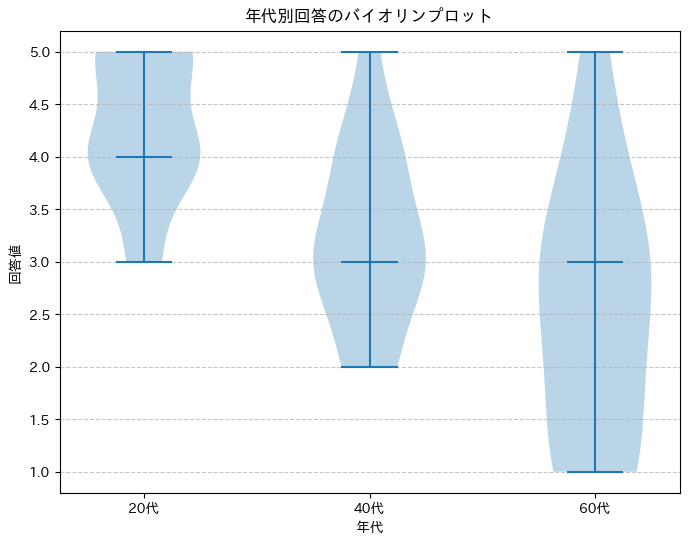

In [ ]:
# 2. バイオリンプロット (Violin Plot)
plt.figure(figsize=(8, 6))
# バイオリンプロットは、箱ひげ図よりデータの分布の形状を詳細に示す。
# showmeans=True: 平均値を表示, showmedians=True: 中央値を表示, showextrema=False: 外れ値を表示しない
plt.violinplot(data_to_plot, showmeans=False, showmedians=True, showextrema=True)

# X軸のティックラベルを設定
plt.xticks(np.arange(1, len(labels) + 1), labels) # 1から始まるインデックスに対応

plt.title('年代別回答のバイオリンプロット')
plt.xlabel('年代')
plt.ylabel('回答値')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()